In [1]:
from dataset.dataset import *
from torch.utils.data import Dataset, DataLoader
import getpass
import os
import socket
import numpy as np
from dataset.preprocess_data import *
from PIL import Image, ImageFilter
import argparse
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from models.model import generate_model
from opts import parse_opts
from torch.autograd import Variable
import time
import sys
from utils import *
#from utils import AverageMeter, calculate_accuracy
import pdb

In [2]:
class dummy():
    batch_size = 32
    split = 1
    annotation_path = "/scratch/tkg5kq/mmaction2/data/hmdb51/annotations/"
    frame_dir = "/scratch/tkg5kq/mmaction2/data/hmdb51/rawframes/"
    only_RGB = True
    dataset = 'HMDB51'
    modality = 'RGB'
    input_channels = 3
    n_classes = 400
    n_finetune_classes = 51
    output_layers = []
    model = 'resnext'
    model_depth = 101
    resnet_shortcut = 'B'
    resnext_cardinality = 32
    ft_begin_index = 4
    sample_size = 112
    sample_duration = 16
    training = True
    freeze_BN = False
    n_workers = 4
    learning_rate = 0.1
    momentum = 0.9
    dampening = 0.9
    weight_decay = 1e-3
    nesterov = False
    optimizer = 'sgd'
    lr_patience = 10
    MARS_alpha = 50
    n_epochs = 400
    begin_epoch = 1
    result_path = ''
    MARS = False
    pretrain_path = ''
    MARS_pretrain_path = ''
    MARS_resume_path = ''
    resume_path1 = ''
    resume_path2 = ''
    resume_path3 = ''
    log = 1
    checkpoint = 2
    manual_seed = 1
    random_seed = 1

opt = dummy()


In [3]:
print("Preprocessing train data ...")
train_data   = globals()['{}_test'.format(opt.dataset)](split = opt.split, train = 1, opt = opt)
print("Length of train data = ", len(train_data))

print("Preprocessing validation data ...")
val_data   = globals()['{}_test'.format(opt.dataset)](split = opt.split, train = 2, opt = opt)
print("Length of validation data = ", len(val_data))

if opt.modality=='RGB': opt.input_channels = 3
elif opt.modality=='Flow': opt.input_channels = 2

print("Preparing datatloaders ...")

Preprocessing train data ...
Length of train data =  3570
Preprocessing validation data ...
Length of validation data =  1530
Preparing datatloaders ...


In [4]:

print("Preparing datatloaders ...")
train_dataloader = DataLoader(train_data, batch_size = opt.batch_size, shuffle=True, num_workers = opt.n_workers, pin_memory = True, drop_last=True)
val_dataloader   = DataLoader(val_data, batch_size = opt.batch_size, shuffle=True, num_workers = opt.n_workers, pin_memory = True, drop_last=True)
print("Length of train datatloader = ",len(train_dataloader))
print("Length of validation datatloader = ",len(val_dataloader))    


Preparing datatloaders ...
Length of train datatloader =  111
Length of validation datatloader =  47


In [78]:
def show_sequence(seq, sample=8, title=''):
    '''Plot a sequence of images horizontally'''
    # clip is [T, H, W, 3]
    # assert (seq.shape[-1] == 3)
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, sample), axes_pad=0.1)
    for ax, img in zip(grid, seq):
        image = (img-np.min(img))/(np.max(img)-np.min(img))
        ax.imshow(image)
        ax.set_axis_off()
    plt.show()
    return

classes = []
with open('/scratch/tkg5kq/mmaction2/data/hmdb51/annotations/classInd.txt', 'r') as f:
    for line in f:
        label = line.split(' ')[1]
        classes.append(label)

i = 0
for result in train_dataloader:
    if i >= 4:
        break
    i += 1



Total_frames 39, sample_duration 16Total_frames 77, sample_duration 16Total_frames 77, sample_duration 16Total_frames 77, sample_duration 16



Total_frames 47, sample_duration 16Total_frames 99, sample_duration 16

Total_frames 37, sample_duration 16Total_frames 52, sample_duration 16

Total_frames 49, sample_duration 16
Total_frames 137, sample_duration 16
Total_frames 171, sample_duration 16
Total_frames 80, sample_duration 16
Total_frames 74, sample_duration 16
Total_frames 78, sample_duration 16
Total_frames 299, sample_duration 16
Total_frames 78, sample_duration 16
Total_frames 45, sample_duration 16
Total_frames 58, sample_duration 16
Total_frames 138, sample_duration 16
Total_frames 81, sample_duration 16
Total_frames 255, sample_duration 16
Total_frames 77, sample_duration 16
Total_frames 79, sample_duration 16
Total_frames 61, sample_duration 16
Total_frames 220, sample_duration 16
Total_frames 77, sample_duration 16
Total_frames 36, sample_duration 16
Total_frames 70, sampl

In [81]:
result[1]

tensor([46, 44, 36, 48, 49, 23, 50, 33,  9, 29,  9, 50,  5, 29,  5, 15, 45, 16,
        28, 32, 35, 43, 48,  4, 39, 43, 39,  7, 15, 49, 43, 22])

(16, 112, 112)
cartwheel



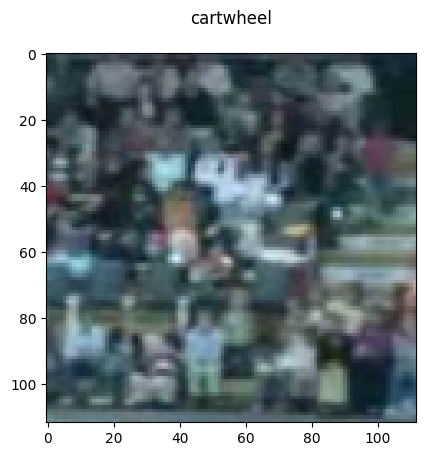

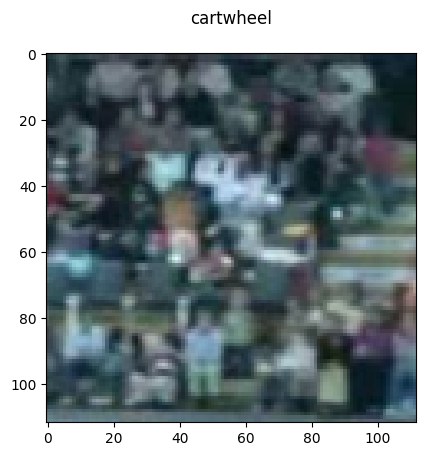

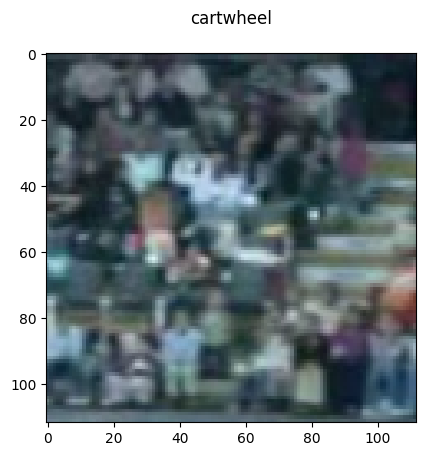

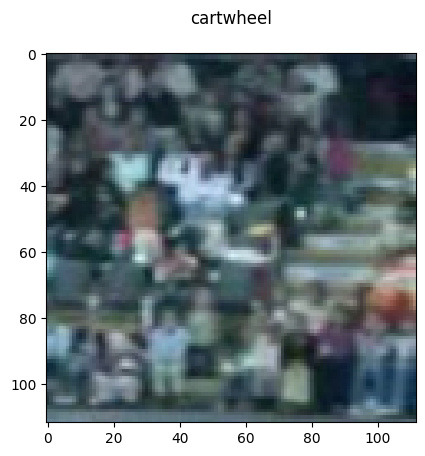

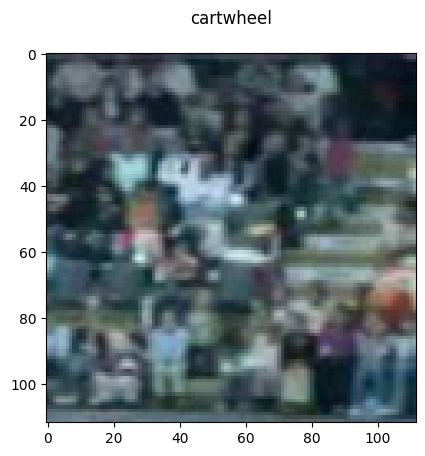

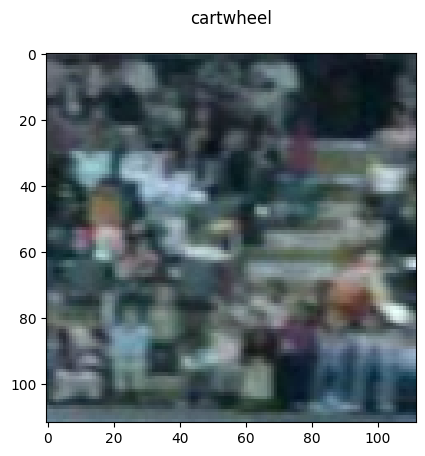

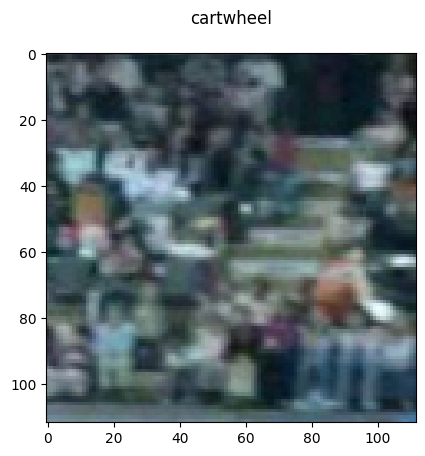

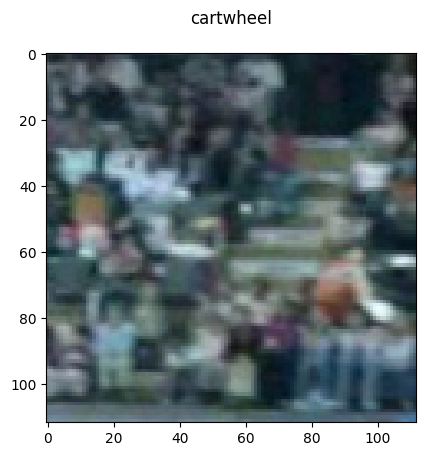

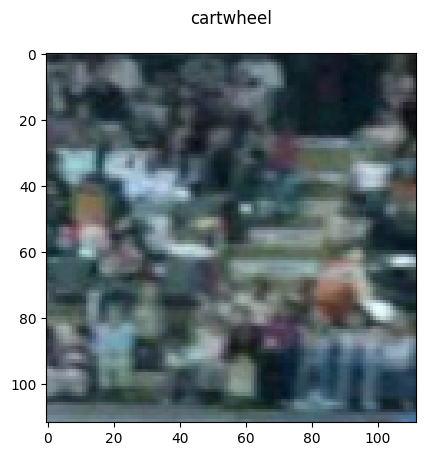

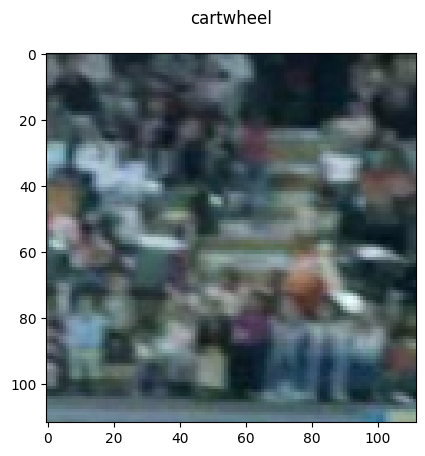

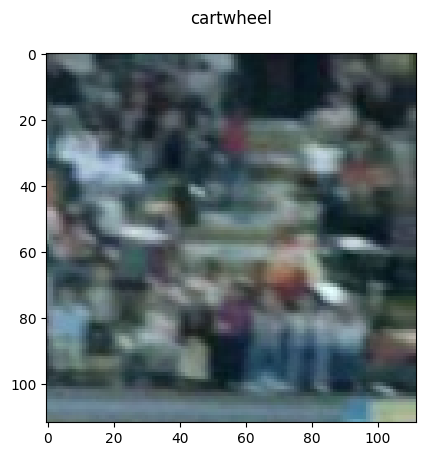

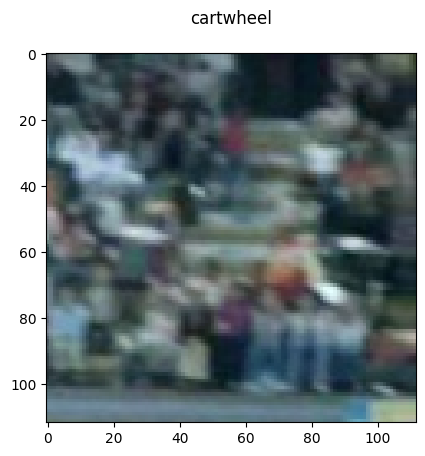

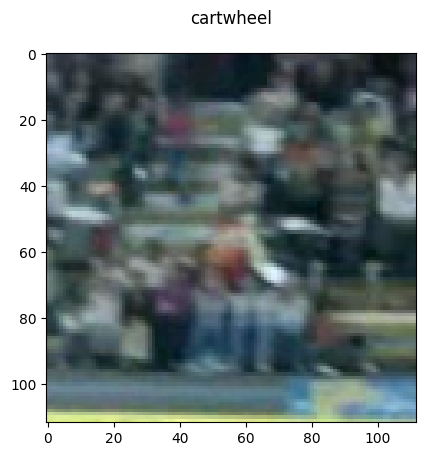

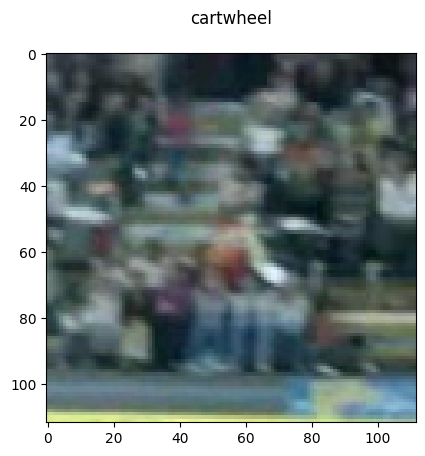

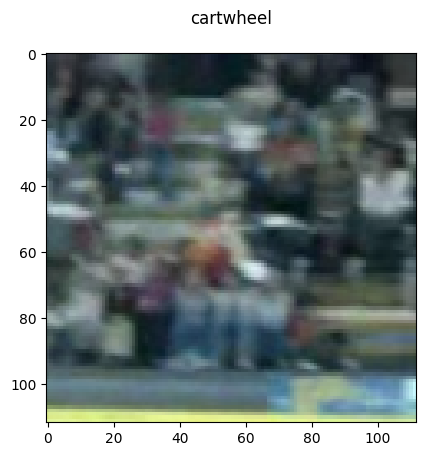

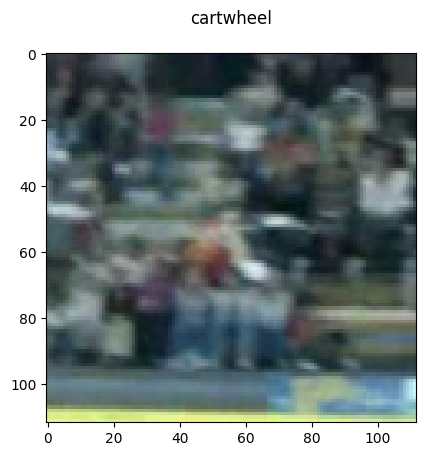

In [84]:
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid

sample1 = x[0].numpy()

print(sample1[0].shape)
print(classes[y[0]])

videos = np.transpose(sample1[:3, :, :, :], axes=[1, 2, 3, 0])
image = videos[0, :, :, :]

for image in videos:
    # Normalize between 0 and 1
    image = (image-np.min(image))/(np.max(image)-np.min(image))
    plt.figure()
    plt.title(f'{classes[y[0]]}')
    plt.imshow(image)
    plt.show()

In [101]:

import os.path as osp
import mmcv

In [105]:
full_path = '/scratch/tkg5kq/mmaction2/data/hmdb51/videos/hug/Calins_gratuits_a_Paris_-_Free_Hugs_France_-_version_longue_hug_u_cm_np2_le_med_9.avi' 
vid_path = 'hug/Calins_gratuits_a_Paris_-_Free_Hugs_France_-_version_longue_hug_u_cm_np2_le_med_9.avi'

In [97]:

args = dummy()
args.out_dir = './'
args.use_opencv = True

act_name = osp.basename(osp.dirname(vid_path))
out_full_path = osp.join(args.out_dir, act_name)

run_success = -1

act_name, out_full_path


('hug', './hug')

In [110]:
# Not like using denseflow,
# Use OpenCV will not make a sub directory with the video name
video_name = osp.splitext(osp.basename(vid_path))[0]
out_full_path = osp.join(out_full_path, video_name)

vr = mmcv.VideoReader(full_path)
wtsu = True
if wtsu:
    vr_tsu = np.transpose(vr, axes=[1, 0, 2, 3])
elif htsu:
    vr_tsu = np.transpose(vr, axes=[2, 1, 0, 3])

np.shape(vr), np.shape(vr_tsu)

((54, 240, 320, 3), (240, 54, 320, 3))

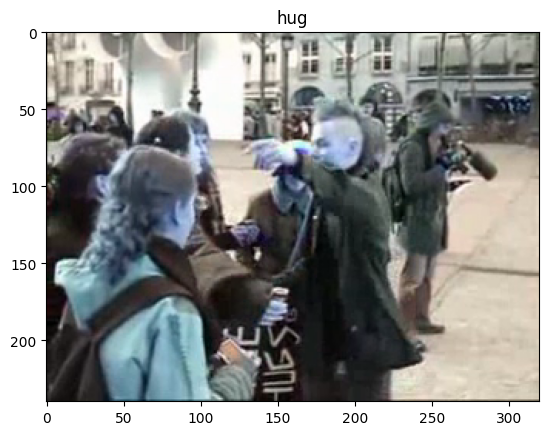

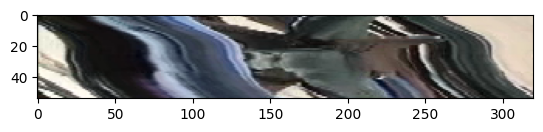

In [115]:
plt.figure()
plt.imshow(vr[0])
plt.title('hug')
plt.show()

plt.figure()
plt.imshow(vr_tsu[120])
plt.show()